In [1]:
import os
import time
import warnings
import numpy as np
import random as rnd
import pandas as pd
from collections import defaultdict

# Librería Genética
from deap import base, creator, tools, algorithms

from sklearn.utils import shuffle
# Subfunciones de estimadores
from sklearn.base import clone
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/base.py][30]
from sklearn.base import is_classifier
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/base.py][535]
from sklearn.model_selection._validation import _fit_and_score
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_validation.py][346]
from sklearn.model_selection._search import BaseSearchCV
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_search.py][386]
from sklearn.model_selection._search import check_cv
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_split.py][1866]
from sklearn.model_selection._search import _check_param_grid
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_search.py][343]
from sklearn.metrics.scorer import check_scoring
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/metrics/scorer.py][250]
from sklearn.utils.validation import _num_samples
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/validation.py][105]
from sklearn.utils.validation import indexable
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/validation.py][208]
from multiprocessing import Pool, Manager, cpu_count
#from itertools import product
import itertools as it #import product

# Selección para estimadores
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metricas para estimadores
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

# Estimadores
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

#Ensembles algorithms
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
# find distance error al 0.2%
def distance_error(estimator, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 7)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    # coord pred
    x1 = np.int32((y_pred + 2) % 3)
    y1 = np.int32((y_pred - 1) / 3)
    # coord real
    x2 = np.int32((y_test + 2) % 3)
    y2 = np.int32((y_test - 1) / 3)
    # pasar variacion a distancias metros
    vx = np.abs(x1 - x2)*1.5
    vy = np.abs(y1 - y2)*1.5
    #vx = vx*0.5 + (vx-1)*(vx>0)
    #vy = vy*0.5 + (vy-1)*(vy>0)
    # pitagoras
    err_distance = np.sqrt(vx*vx + vy*vy)
    return err_distance

#def _createDataset(frecuencias, values, seed = 7):
def _createDataset(frecuencias, values):
    # crear dataset
    names_ = frecuencias[0].columns.values
    seed = 7
    # reestructuracion
    salida_final = pd.DataFrame(columns=names_)
    for sec in range(1,16):
        dataset = pd.DataFrame(columns=names_)
        corte = min([frecuencias[i][frecuencias[i]['Sector']==sec].shape[0] for i in values])
        #l = [frecuencias[i][frecuencias[i]['Sector']==sec].shape[0] for i in values]
        #corte = max(l)
        #tx=l.index(max(l))
        tx = 0
        dataset[names_[tx]] = dataset[names_[tx]].append(frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx]])
        dataset = dataset.reset_index(drop=True)
        for tx in range(1,5):
            dataset[names_[tx]] = frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx]].reset_index(drop=True)
        dataset[names_[tx+1]] = frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx+1]].reset_index(drop=True)
        # join parts
        salida_final = salida_final.append(dataset)
    # shuffle dataset
    salida_final = shuffle(salida_final, random_state=seed).reset_index(drop=True)
    salida_final = salida_final.apply(pd.to_numeric)
    # dataframe to X,y 
    X = salida_final[names_[:-1]]
    y = salida_final[names_[-1]]
    return X,y

def set_models():
    rs = 1
    models = []
    # LDA : Warning(Variables are collinear)
    models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
    models.append(('SVC', SVC(random_state=rs)))
    models.append(('GaussianNB', GaussianNB()))
    models.append(('MLPClassifier', MLPClassifier()))
    models.append(('KNeighborsClassifier', KNeighborsClassifier()))
    models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state=rs)))
    models.append(('LogisticRegression', LogisticRegression()))
    # Bagging and Boosting
    # models.append(('ExtraTreesClassifier', ExtraTreesClassifier(n_estimators=150)))
    models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state=rs)))
    models.append(('AdaBoostClassifier', AdaBoostClassifier(DecisionTreeClassifier(random_state=rs),
                                                            random_state=rs)))
    # models.append(('AdaBoostClassifier', AdaBoostClassifier(DecisionTreeClassifier())))
    models.append(('RandomForestClassifier', RandomForestClassifier(random_state=rs)))
    models.append(('GradientBoostingClassifier',
                   GradientBoostingClassifier(random_state=rs)))
    # models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
    # Voting
    estimators = []
    estimators.append(("Voting_GradientBoostingClassifier", GradientBoostingClassifier(random_state=rs)))
    estimators.append(("Voting_ExtraTreesClassifier", ExtraTreesClassifier(random_state=rs)))
    voting = VotingClassifier(estimators)
    models.append(('VotingClassifier', voting))
    return models

# The problem to optimize
def getAccuracy( frecuencias, individual, estimator, score_cache, resultados ):
	X,y = _createDataset(frecuencias, individual)
	#print(X)
	#print
	#print
	#print(y)
	score = 0
	scorer = "accuracy"
	name = str(estimator).split('(')[0]
	paramkey = str(np.int32(individual)+1)
	if paramkey in score_cache:
		score = score_cache[paramkey]
	else:
		kfold = KFold(n_splits=10, shuffle=False)
		cv_results = cross_val_score(estimator, X, y, cv=kfold, scoring=scorer)
		#print(name,"  ",paramkey,"   ")
		#print(len(X),"  ",len(y),"   ", kfold)
		score = cv_results.mean()
		desv = cv_results.std()
		error = distance_error(estimator, X, y)
		score_cache[paramkey] = score
		dict_result = {'Modelo': name, 'Configuracion':np.int32(individual)+1, 'values': cv_results, 'Accuracy': score, 'stdAccuracy': desv, 'errorMetrico': np.mean(error), 'error': error }
		resultados.append(dict_result)
	return score
"""
def _evalFunction(individual, frecuencias, scorer, num_folds, score_cache, desv_cache, error_cache, resultados_cache):
	X, y = _individual_to_params(frecuencias, individual)
	score = 0
	n_test = 0
	name = str(individual.est).split('(')[0]
	paramkey = str(np.array(individual)+1)
	if paramkey in score_cache:
		score = score_cache[paramkey]
	else:
		kfold = KFold(n_splits=10, shuffle=False)
		#cv_results = cross_val_score(estimator, X, y, cv=kfold, scoring=scoring)
		cv_results = cross_val_score(individual.est, X, y, cv=kfold, scoring=scorer)
		score = cv_results.mean()
		score_cache[paramkey] = score
		desv_cache[paramkey] = cv_results.std()
		error_cache[paramkey] = distance_error(individual.est, X, y)
		results = {'Modelo': name, 'Configuracion':np.int32(individual)+1, 'values': cv_results, 'Accuracy': score, 'stdAccuracy': desv_cache[paramkey], 'errorMetrico': error_cache[paramkey]}  
		resultados_cache.append(results)
	return (score,)
"""


class eda:
	def __init__(self, of, frecuencias, estimator):
		# Algorithm parameters
		self.iterations = 10
		self.sample_size = 100
		self.select_ratio = 0.5
		self.epsilon = 10e-6

		# class members
		self.objective_function = of
		self.dimensions = 5
		self.sample = []
		self.means = []
		self.stdevs = []	

		self.debug = False
		# aditional parameters
		self.frecuencias = frecuencias
		self.estimator = estimator
		self.__manager = Manager()
		self.score_cache = {}
		self.resultados = self.__manager.list()
		self.n_jobs = cpu_count()
        

	def sample_sort(self): 
		# sort rows on the last column
		self.sample = self.sample[ np.argsort( self.sample[:,-1], 0 ) ]


	def dispersion_reduction(self):
		self.sample_sort()

		# number of points to select
		nb = int( np.floor( self.sample_size * self.select_ratio ) )

		# selection
		#self.sample = self.sample[:nb]
		self.sample = self.sample[self.sample_size-nb:]

		if self.debug:
			print ("dispersion reduction")
			print (str(self.sample))
			print


	def estimate_parameters( self ):
		# points sub array (without values)
		mat = self.sample[:,:self.dimensions]
		
		# row means (axis 0 in scipy)
		self.means = np.mean( mat, 0 )
		
		# row standard deviation
		self.stdevs = np.std( mat, 0 )

		if self.debug:
			print ("estimate parameters")
			print ("\tmean=" +str(self.means))
			print ("\tstd-dev=" + str(self.stdevs))
			print


	def draw_sample(self):
		# for each variable to optimize
		for i in range(self.dimensions):
			# if the dispersion is null
			if self.stdevs[i] == 0.0:
				# set it to a minimal value
				self.stdevs[i] = self.epsilon
		
		# empty sample
		self.sample = np.zeros( (self.sample_size, self.dimensions+1) )
		
		# for each point
		for i in range( self.sample_size ):
			# draw in random normal
			p = np.random.normal( self.means, self.stdevs )
			p = np.array([0 if i<0 else (5 if i>5 else i) for i in p])
			# put it into the sample
			self.sample[i][:self.dimensions] = np.round(p)%(self.dimensions+1)

		if self.debug:
			print ("draw sample")
			print (self.sample)
			print


	def evaluate(self):
		# for each point
		"""
		for i in range( self.sample_size ):
			d = self.dimensions
			# call the objective function
			#   the third element is the result of the objective function call
			#   taking the first two elements as variables
			#r = self.objective_function( self.frecuencias, self.sample[i][:d], self.estimator, self.score_cache )
			#self.sample[i][-1] = r
			self.sample[i][-1] = self.objective_function( self.frecuencias, self.sample[i][:d], self.estimator, self.score_cache , self.resultados)
		"""
		d = self.dimensions
		_pool = Pool(self.n_jobs)
		#self.sample[i][-1] = self.objective_function( self.frecuencias, self.sample[i][:d], self.estimator, self.score_cache , self.resultados)
		_iterable = it.product([self.frecuencias], np.int32(self.sample[:,:d]), [self.estimator], [self.score_cache], [self.resultados])
		self.sample[:,-1] = _pool.starmap(self.objective_function, _iterable)
		_pool.close()
		_pool.join()
		#getAccuracy( frecuencias, individual, estimator, score_cache, resultados ):
		if self.debug:
			print ("evaluate")
			print (self.sample)
			print


	def run(self):
		# uniform initialization
		self.sample = np.random.rand( self.sample_size, self.dimensions+1 )
		# cosmetic
		#self.sample = self.sample * 200 - 100
		top_freq = 6
		self.sample = np.floor(np.random.rand(self.sample_size, self.dimensions +1)*top_freq)
		
		if self.debug:
			print ("initialization")
			print (self.sample)
			print

		self.evaluate()

		# Multi process
		
		i = 0
		while i < self.iterations:
			if self.debug:
				print ("iteration",i)
				print

			i += 1
			self.dispersion_reduction()
			print("iter["+str(i)+"]-top1: "+str(self.sample[-1]))
			self.estimate_parameters()
			self.draw_sample()
			self.evaluate()
			# print top 1
			self.sample_sort()

		# sort the final sample
		self.sample_sort()
		# output the optimum
		#self.pool.close()
		#self.pool.join()
		ranking = self.sample_size
		#print ("#[ Configuración ]\t Accuracy")
		#for i in range(ranking):
		#	linea = str(self.sample[-i-1][:-1]+1) + "\t" +str(self.sample[-i-1][-1])
		#	print(linea)


In [3]:
test_size = 0.2
num_folds = 10
seed = 7
frecuencias = []
names_ = ['Be01', 'Be02', 'Be03', 'Be04', 'Be05', 'Sector']

frecuencias.append(pd.read_csv('sinFiltro/Tx_0x01'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x02'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x03'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x04'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x05'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x06'))#, names=names_))

In [4]:
#n_neighbors = 5 7 11
#weights = 'distance'
#algorithm = 'kd_tree' 'ball_tree'
#estimator = KNeighborsClassifier(n_jobs=8, weights = 'distance', n_neighbors = 5, algorithm = 'kd_tree')
#a = eda( getAccuracy, frecuencias, estimator )
#a.run()

"""

def set_models():
    rs = 1
    models = []
    models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
    models.append(('KNeighborsClassifier', KNeighborsClassifier()))
    return models
"""
estimadores = set_models()

#reserva = {}
lista_resultados = []
for name, model in estimadores:
    print("\nModeling...", name)
    splits = 10
    #simetricas = [[i]*5 for i in range(6)]
    #for individual in simetricas:
    #acc, desv, err = evaluate(frecuencias, individual, model)
    #salida[str(name)+"-"+str(individual)] = str(acc) + "-"+ str(desv) + "-" + str(err)
    #print(name," ", individual, "\t", acc, "\t", desv, "\t", err)
    #gs = EvolutiveSearchCV(estimator=model, scoring="accuracy", num_folds=10, n_jobs=num_jobs,
    #                    verbose=True, refit=True, 
    #                    population_size=100, 
    #                    gene_mutation_prob=0.3, 
    #                    gene_crossover_prob=0.5,
    #                    tournament_size=4,
    #                    generations_number=10)
    a = eda( getAccuracy, frecuencias, model )
    a.run()
    #gs.fit(frecuencias)
    #reserva[name]=(gs.score_cache, gs.desv_cache , gs.error_cache)
    lista_resultados = lista_resultados + list(a.resultados)
    


Modeling... LinearDiscriminantAnalysis
iter[1]-top1: [ 5.          0.          0.          5.          4.          0.74510763]
iter[2]-top1: [ 5.          0.          2.          2.          5.          0.72744946]
iter[3]-top1: [ 5.          0.          2.          0.          4.          0.75297214]
iter[4]-top1: [ 5.          0.          2.          0.          0.          0.73380345]
iter[5]-top1: [ 3.          0.          1.          0.          0.          0.73609261]
iter[6]-top1: [ 3.          0.          3.          2.          0.          0.74027304]
iter[7]-top1: [ 5.          3.          3.          2.          0.          0.71442543]
iter[8]-top1: [ 5.          3.          2.          0.          0.          0.71809291]
iter[9]-top1: [ 5.          4.          3.          2.          0.          0.72911702]
iter[10]-top1: [ 5.          3.          2.          0.          0.          0.71809291]

Modeling... SVC
iter[1]-top1: [ 3.          0.          5.          5.        

iter[1]-top1: [ 5.          4.          2.          2.          0.          0.86471452]
iter[2]-top1: [ 5.          0.          1.          0.          0.          0.87168938]
iter[3]-top1: [ 5.          3.          2.          2.          1.          0.87373352]
iter[4]-top1: [ 5.          0.          5.          2.          0.          0.87264834]
iter[5]-top1: [ 5.          0.          2.          2.          5.          0.86726996]
iter[6]-top1: [ 5.          5.          1.          2.          1.          0.86212476]
iter[7]-top1: [ 5.          3.          2.          2.          1.          0.87373352]
iter[8]-top1: [ 5.          0.          2.          2.          0.          0.88241815]
iter[9]-top1: [ 5.          3.          2.          2.          1.          0.87373352]
iter[10]-top1: [ 5.          3.          2.          2.          1.          0.87373352]

Modeling... GradientBoostingClassifier
iter[1]-top1: [ 5.          3.          3.          2.          5.          0.8

In [27]:
df = pd.DataFrame(lista_resultados).sort_values(['Accuracy'],ascending=False).drop_duplicates(subset=['Modelo', 'Accuracy', 'stdAccuracy', 'errorMetrico'])
df[['Modelo', 'Configuracion', 'Accuracy', 'stdAccuracy', 'errorMetrico']].to_csv('EDAS_resultados.csv', sep=',', index=False) 
display(df[['Modelo', 'Configuracion', 'Accuracy', 'stdAccuracy', 'errorMetrico']])

,Modelo,Configuracion,Accuracy,stdAccuracy,errorMetrico
11561,GradientBoostingClassifier,"[6, 1, 3, 3, 5]",0.914520,0.008447,0.185316
12266,VotingClassifier,"[6, 1, 3, 3, 5]",0.904359,0.010358,0.199940
11645,GradientBoostingClassifier,"[6, 1, 1, 3, 3]",0.901487,0.013594,0.217585
11880,GradientBoostingClassifier,"[6, 3, 2, 3, 5]",0.900296,0.012720,0.285474
11053,GradientBoostingClassifier,"[6, 1, 1, 3, 4]",0.899511,0.013050,0.213565
11560,GradientBoostingClassifier,"[6, 1, 2, 3, 4]",0.899267,0.012695,0.282091
11919,GradientBoostingClassifier,"[6, 5, 2, 3, 4]",0.897565,0.009551,0.253806
11361,GradientBoostingClassifier,"[6, 1, 3, 3, 3]",0.896850,0.009726,0.205363
11613,GradientBoostingClassifier,"[6, 1, 3, 3, 1]",0.895867,0.009047,0.221426
11201,GradientBoostingClassifier,"[6, 1, 6, 3, 4]",0.894377,0.015300,0.351797


In [28]:
#topDf = df.drop_duplicates(subset=['Modelo'])
#display(topDf)
#pd.DataFrame(salida).sort_values(['Accuracy'], ascending=False)
topDf=df.drop_duplicates(subset=['Modelo'])#.drop_duplicates()
topDf[['Modelo', 'Configuracion', 'Accuracy', 'stdAccuracy', 'errorMetrico']].to_csv('EDAS_resultados_unique.csv', sep=',', index=False) 
display(topDf[['Modelo', 'Configuracion', 'Accuracy', 'stdAccuracy', 'errorMetrico']])

,Modelo,Configuracion,Accuracy,stdAccuracy,errorMetrico
11561,GradientBoostingClassifier,"[6, 1, 3, 3, 5]",0.914520,0.008447,0.185316
12266,VotingClassifier,"[6, 1, 3, 3, 5]",0.904359,0.010358,0.199940
10641,RandomForestClassifier,"[6, 1, 3, 3, 1]",0.882418,0.009747,0.286972
9771,AdaBoostClassifier,"[6, 1, 1, 3, 1]",0.881202,0.012816,0.258637
7702,ExtraTreesClassifier,"[6, 6, 3, 3, 2]",0.867943,0.013143,0.399393
4986,KNeighborsClassifier,"[6, 1, 3, 3, 1]",0.866293,0.011922,0.280348
2847,GaussianNB,"[6, 1, 3, 4, 5]",0.845358,0.018558,0.341620
5890,DecisionTreeClassifier,"[6, 1, 3, 3, 1]",0.832070,0.010714,0.357042
1255,SVC,"[5, 1, 3, 6, 1]",0.827804,0.019018,0.404551
233,LinearDiscriminantAnalysis,"[6, 1, 3, 1, 5]",0.752972,0.014543,0.511191


In [29]:

#dataframe_plot = topDf
def column_boxplot(dataframe_plot, column_plot, filename, box_bool=True):
    %pylab inline
    pylab.rcParams['figure.figsize'] = (14, 8)
    previos = ['LogisticRegression', 'LinearDiscriminantAnalysis', 'GaussianNB', 'MLPClassifier', 
               'SVC', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'RandomForestClassifier', 
               'ExtraTreesClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'VotingClassifier']
    nuevos = ['LoR', 'LDA', 'GNB', 'MLP', 'SVC', 'DT', 'k-NN', 'RF', 'ET', 'GBM', 'AB', 'VC']
    num_models = len(nuevos)
    dataframe_plot = dataframe_plot[['Modelo', 'Configuracion', 'Accuracy', 'errorMetrico', 'values', 'error']]
    for i in range(num_models):
        dataframe_plot['Modelo'] = dataframe_plot['Modelo'].str.replace(previos[i], nuevos[i])
        #df['Modelo'] = df['Modelo'].str.replace('LinearDiscriminantAnalysis','LDA')
    sorterIndex = dict(zip(nuevos,range(num_models)))
    #test
    dataframe_plot['Model_Rank'] = dataframe_plot['Modelo'].map(sorterIndex)
    dataframe_plot = dataframe_plot.sort_values(['Model_Rank'],ascending=True).reset_index(drop=True)[dataframe_plot.columns[:-1]]
    if column_plot == 'values':
        y_label = 'Score'
        x_label = 'Model'
    else:
        y_label = 'Error (m)'
        x_label = 'Model Evaluated'
    lista_plot = []
    for i in range(num_models):
        num_splits = len(list(dataframe_plot[column_plot])[i])
        for j in range(num_splits):
            d = {x_label:nuevos[i], y_label:dataframe_plot[column_plot][i][j]}
            lista_plot.append(d)
    #pd.DataFrame(lista_plot)
    sns.set_style("whitegrid")
    if column_plot == 'values':
        ax_plot = sns.boxplot(data=pd.DataFrame(lista_plot), x=x_label, y=y_label, linewidth = 1.0)
    else:
        #ax_plot = sns.barplot(data=pd.DataFrame(lista_plot), x=x_label, y=y_label, linewidth = 1.0)
        if box_bool==True:
            ax_plot = sns.boxplot(data=pd.DataFrame(lista_plot), x=x_label, y=y_label, linewidth = 1.0)
        else:
            ax_plot = sns.barplot(data=pd.DataFrame(lista_plot), x=x_label, y=y_label, linewidth = 1.0)
    plt.format='eps'
    if column_plot == 'values':
        medians = np.round(list(dataframe_plot['Accuracy']),3)
        tope = 0.98
    else:
        medians = np.round(list(dataframe_plot['errorMetrico']),3)
        if box_bool==True:
            tope = 6.8
        else:
            tope = 2.8
    median_labels = [str(s) for s in medians]
    pos = range(num_models)
    for tick,label in zip(pos,ax_plot.get_xticklabels()):
        ax_plot.text(pos[tick], tope, median_labels[tick], 
                horizontalalignment='center', color='black') #, weight='semibold'
    axes = plt.gca()
    if column_plot == 'values':
        axes.set_ylim([0.3,1.0])
    else:
        axes.set_ylim([-0.1, tope+0.2])
    plt.savefig(filename + ".eps")
    plt.show()


## Accuracy EDAS

Populating the interactive namespace from numpy and matplotlib


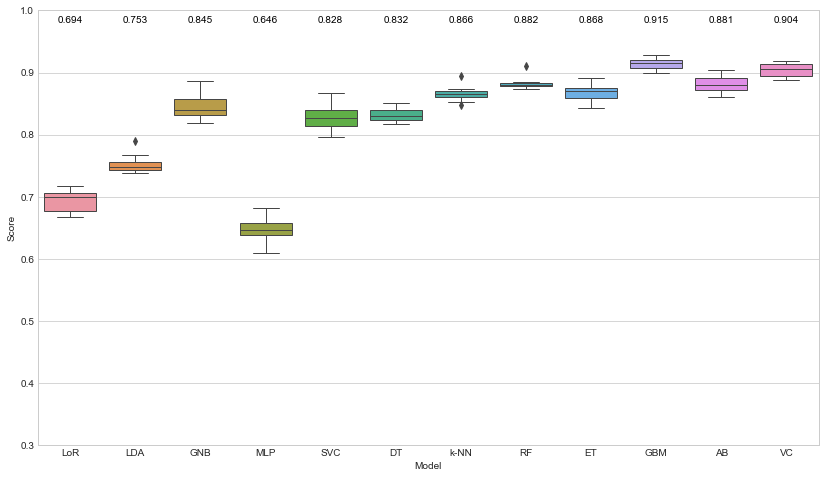

In [17]:
column_boxplot(topDf, 'values', 'accuracy_edas')

## Error EDAS Boxplot

Populating the interactive namespace from numpy and matplotlib


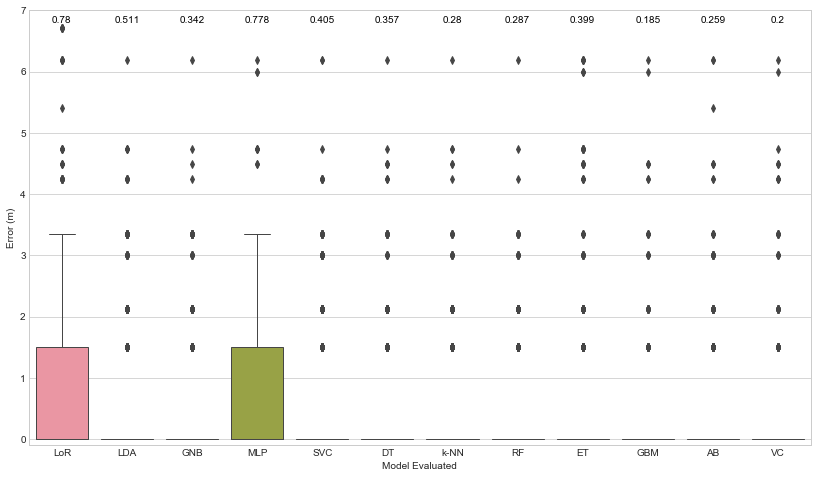

In [30]:
column_boxplot(topDf, 'error', 'error_edas')

Populating the interactive namespace from numpy and matplotlib


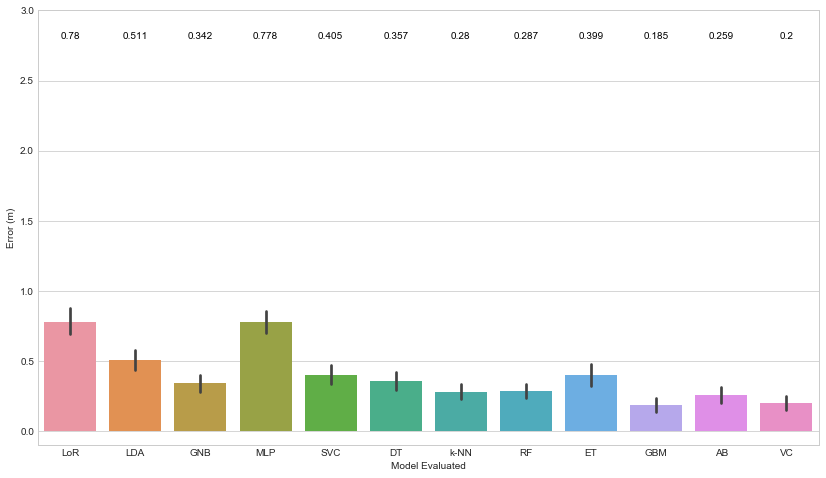

In [31]:
column_boxplot(topDf, 'error', 'error_edas', box_bool=False)

In [12]:
topDf

,Accuracy,Configuracion,Modelo,error,errorMetrico,stdAccuracy,values
11561,0.914520,"[6, 1, 3, 3, 5]",GradientBoostingClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 2.12132034356, 0.0, ...",0.185316,0.008447,"[0.915841584158, 0.898514851485, 0.91584158415..."
12266,0.904359,"[6, 1, 3, 3, 5]",VotingClassifier,"[0.0, 0.0, 3.35410196625, 0.0, 0.0, 0.0, 0.0, ...",0.199940,0.010358,"[0.915841584158, 0.905940594059, 0.89108910891..."
10641,0.882418,"[6, 1, 3, 3, 1]",RandomForestClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.286972,0.009747,"[0.909756097561, 0.872860635697, 0.88264058679..."
9771,0.881202,"[6, 1, 1, 3, 1]",AdaBoostClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.121...",0.258637,0.012816,"[0.885365853659, 0.892420537897, 0.88753056234..."
7702,0.867943,"[6, 6, 3, 3, 2]",ExtraTreesClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.399393,0.013143,"[0.878934624697, 0.891041162228, 0.84261501210..."
4986,0.866293,"[6, 1, 3, 3, 1]",KNeighborsClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.121...",0.280348,0.011922,"[0.863414634146, 0.867970660147, 0.86797066014..."
2847,0.845358,"[6, 1, 3, 4, 5]",GaussianNB,"[0.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.341620,0.018558,"[0.831683168317, 0.861386138614, 0.83168316831..."
5890,0.832070,"[6, 1, 3, 3, 1]",DecisionTreeClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.121...",0.357042,0.010714,"[0.831707317073, 0.821515892421, 0.81907090464..."
1255,0.827804,"[5, 1, 3, 6, 1]",SVC,"[0.0, 0.0, 0.0, 2.12132034356, 0.0, 0.0, 0.0, ...",0.404551,0.019018,"[0.79702970297, 0.836633663366, 0.821782178218..."
233,0.752972,"[6, 1, 3, 1, 5]",LinearDiscriminantAnalysis,"[0.0, 2.12132034356, 3.0, 0.0, 0.0, 1.5, 0.0, ...",0.511191,0.014543,"[0.737623762376, 0.789603960396, 0.74752475247..."
